### Importation des bilbliothèques

In [12]:
import matplotlib.pyplot as plt

import numpy as np

import cv2
import time
from skimage import color, transform
from skimage.feature import hog
import imutils

import joblib

Taille de nos patches, associée à notre modèle

In [24]:
positive_patches_shape = (62, 47)

L'image étudiée est de taille (300, 267)


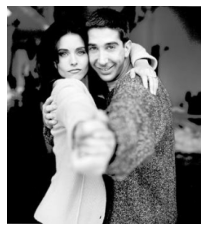

In [292]:
test_image = cv2.imread('img/ew-courtney-david.jpg') 

test_image = color.rgb2gray(test_image)

# Paramètre dont on étudiera l'influence
(H_MAX, W_MAX) = (300, 600)

if test_image.shape[0] > H_MAX or test_image.shape[1] > W_MAX:
    s = min(H_MAX / test_image.shape[0], W_MAX / test_image.shape[1])
    test_image = transform.rescale(test_image, s)
    
print("L'image étudiée est de taille {}".format(test_image.shape))

plt.imshow(test_image, cmap="gray")
plt.axis('off');

### Image pyramid, sliding window

*Momentanément, on n'utilise pas la pyramide d'images*

In [15]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
    yield image

    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        
        if image.shape[0] < minSize[0] or image.shape[1] < minSize[1]:
            break
        
        yield image

In [266]:
def sliding_window(img, patch_size, istep=4, jstep=4, scale=1.0):
    
    Ni, Nj = (int(scale * s) for s in patch_size)
    # La sliding window a une taille Ni*Nj
    
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

### Extraction des patches

On a un total de 3120 patches.

Temps d'exécution: 2.56 secondes



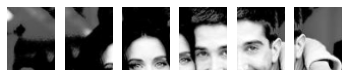

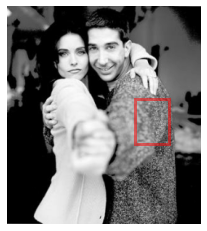

In [296]:
indices, patches = [], []

start = time.time()

'''
pyrlayers = 0
for (i, resized) in enumerate(pyramid(test_image)):
    if resized.shape > positive_patches_shape:
        # On applique la sliding window sur la couche de la pyramide en cours
        print(resized.shape)
        pyrindices, pyrpatches = zip(*sliding_window(resized, positive_patches_shape, i+1, scale=1.0))
        indices += pyrindices
        patches += pyrpatches
        pyrlayers += 1

    
print("La pyramide présente {} couches.".format(pyrlayers))

'''

s = 1.0

indices, patches = zip(*sliding_window(test_image, positive_patches_shape, scale=s))

Ni, Nj = (int(s * e) for e in positive_patches_shape)

print("On a un total de {} patches.".format(len(patches)))
    
indices = np.array(indices)


fig, axs = plt.subplots(1,6)
for i in range(6):
    axs[i].imshow(patches[i*60], cmap='gray')
    axs[i].axis('off')

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
    
ax.add_patch(plt.Rectangle(indices[2320], Nj, Ni, edgecolor='red', alpha=0.5, lw=3, facecolor='none'))
            
patches_hog = np.array([hog(patch) for patch in patches])
patches_hog.shape

print("\nTemps d'exécution: {} secondes\n".format(round(time.time()-start, 2)))

*Momentanément évité*
Mise en évidence du souci sur la localisation des régions.
Les indices ne collent pas à la bonne taille d'image.

[184 224]


(-0.5, 46.5, 61.5, -0.5)

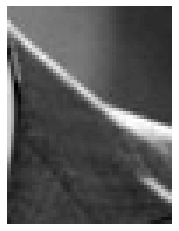

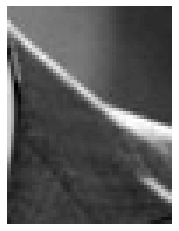

In [89]:
fig, ax = plt.subplots()
print(indices[3000])
ax.imshow(patches[3000], cmap='gray')
ax.axis('off')

fig, ax = plt.subplots()
ax.imshow(test_image[indices[3000][0]: indices[3000][0]+Ni, indices[3000][1]: indices[3000][1]+Nj] , cmap='gray')
ax.axis('off')

### Prédiction

In [297]:
# Chargement du modèle
filename = 'temp_model.sav'
loaded_model = joblib.load(filename)

start = time.time()

# Prédictions
labels = loaded_model.predict(patches_hog)

pred = []
for k in range(len(indices)):
    if labels[k] == 1:
        (i, j) = indices[k]
        pred.append(((i, j), round(loaded_model.decision_function(patches_hog)[k], 3)))
print(pred)

print("\n{} zones positives trouvées.".format(int(labels.sum())))
print("\nTemps d'exécution: {} secondes".format(round(time.time()-start, 5)))

[((4, 0), 0.719), ((8, 0), 0.186), ((12, 0), 0.119), ((12, 16), 0.157), ((12, 20), 0.384), ((12, 24), 0.836), ((12, 120), 0.152), ((28, 108), 0.254), ((32, 108), 2.63), ((32, 112), 2.489), ((32, 116), 0.836), ((32, 168), 0.793), ((36, 64), 2.345), ((36, 68), 2.924), ((36, 72), 0.793), ((36, 104), 0.285), ((36, 108), 2.304), ((36, 112), 2.139), ((36, 116), 0.659), ((40, 64), 3.094), ((40, 68), 5.396), ((40, 72), 2.489), ((40, 108), 1.332), ((40, 112), 1.454), ((40, 116), 0.444), ((44, 64), 3.047), ((44, 68), 4.704), ((44, 72), 1.698), ((48, 64), 1.072), ((48, 68), 2.21), ((48, 72), 0.261), ((56, 108), 0.074), ((56, 120), 0.059), ((60, 108), 1.818), ((60, 112), 0.0), ((60, 120), 0.051), ((64, 108), 0.49), ((68, 108), 0.261), ((76, 112), 0.342), ((116, 48), 0.133), ((120, 48), 0.351), ((124, 48), 0.849), ((128, 44), 0.083), ((128, 48), 0.551), ((156, 88), 0.361), ((156, 92), 0.888), ((156, 96), 0.018), ((160, 84), 0.302), ((160, 88), 0.87), ((160, 92), 1.469), ((160, 96), 1.214), ((160, 1

### Affichage des résultats

  Zone Confiance 
     1:  0.719     
     2:  0.186     
     3:  0.119     
     4:  0.157     
     5:  0.384     
     6:  0.836     
     7:  0.152     
     8:  0.254     
     9:  2.63      
    10:  2.489     
    11:  0.836     
    12:  0.793     
    13:  2.345     
    14:  2.924     
    15:  0.793     
    16:  0.285     
    17:  2.304     
    18:  2.139     
    19:  0.659     
    20:  3.094     
    21:  5.396     
    22:  2.489     
    23:  1.332     
    24:  1.454     
    25:  0.444     
    26:  3.047     
    27:  4.704     
    28:  1.698     
    29:  1.072     
    30:  2.21      
    31:  0.261     
    32:  0.074     
    33:  0.059     
    34:  1.818     
    35:  0.0       
    36:  0.051     
    37:  0.49      
    38:  0.261     
    39:  0.342     
    40:  0.133     
    41:  0.351     
    42:  0.849     
    43:  0.083     
    44:  0.551     
    45:  0.361     
    46:  0.888     
    47:  0.018     
    48:  0.302     
    49:  0.87      
  

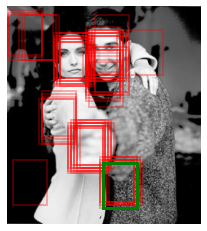

In [298]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

indices = np.array(indices)

print("{:>6} {:<10}".format("Zone", "Confiance"))
for (k, ((i, j), conf)) in enumerate(pred):
        print("{:>6}:  {:<10}".format(k+1, conf))
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))
        
best = max(pred, key=lambda item: item[1])
ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='green',
                               alpha=1, lw=3, facecolor='none'))

    
positive_patches = np.array(positive_patches)

### Non-maxima suppression
On doit combiner les patches qui se superposent

In [212]:
iou_tresh = 0.2

def IOU(bboxes1, bboxes2):
    # Calcule la distance de Jaccard entre bboxes1 et bboxes2
    print(bboxes1)
    bboxes1 = [int(i) for i in bboxes1]
    bboxes2= [int(i) for i in bboxes2]

    # Intersection
    xA = max(bboxes1[0], bboxes2[0])
    yA = max(bboxes1[1], bboxes2[1])
    xB = min(bboxes1[2], bboxes2[2])
    yB = min(bboxes1[3], bboxes2[3])

    # Aire de l'intersection
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    box1_area = (bboxes1[2] - bboxes1[0] + 1) * (bboxes1[3] - bboxes1[1] + 1)
    box2_area = (bboxes2[2] - bboxes2[0] + 1) * (bboxes2[3] - bboxes2[1] + 1)

    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou

In [213]:
def nms(bboxes_list):
    req_bboxes, final_boxes = [], []

    for coord in bboxes_list: 
        prob = float(coord[4])
        if prob > 0.5:
            req_bboxes.append(coord)

    # sorting the bounding boxes based on probability score
    bboxes_sorted = sorted(req_bboxes, reverse=True, key=lambda x: x[4])

    while len(bboxes_sorted) > 0:
        # removing the best probability bounding box
        box = bboxes_sorted.pop(0)

        for b in bboxes_sorted:
            # comparing with the same class
            if box[0] == b[0]:
                try:
                    iou1 = IOU(box[1:-1], b[1:-1])
                    
                    if iou1 >= iou_tresh:
                        # if IOU is large then discard the box with lowest probability
                        bboxes_sorted.remove(b)
                except:
                    pass
        print(len(bboxes_sorted))

        final_boxes.append(box)

    return final_boxes

[(44, 32, 91, 94, 0.8016883264372403), (48, 32, 95, 94, 0.8781148883938847), (52, 32, 99, 94, 0.592361337104613), (60, 32, 107, 94, 0.30114906935377483), (44, 36, 91, 98, 1.959508455558165), (48, 36, 95, 98, 1.4671002889265994), (52, 36, 99, 98, 0.3601210370911687), (56, 36, 103, 98, 0.6128078090009339), (60, 36, 107, 98, 0.51267212347617), (44, 40, 91, 102, 2.134496495817647), (48, 40, 95, 102, 0.9241324132176709), (60, 40, 107, 102, 0.09822937048357794), (44, 44, 91, 106, 0.5448915388738556), (48, 44, 95, 106, 0.2125890253082634), (60, 44, 107, 106, 0.5066434967050419)]
[ 40.  91. 102.]
[ 40.  91. 102.]
[ 40.  91. 102.]
10
[36. 91. 98.]
[36. 91. 98.]
9
[36. 95. 98.]
[36. 95. 98.]
8
[ 40.  95. 102.]
7
6
[32. 91. 94.]
5
4
3
2
[ 36. 107.  98.]
1
0
[array([ 44.       ,  40.       ,  91.       , 102.       ,   2.1344965]), array([44.        , 36.        , 91.        , 98.        ,  1.95950846]), array([48.        , 36.        , 95.        , 98.        ,  1.46710029]), array([ 48.        ,

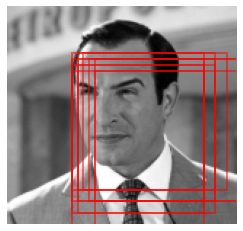

In [214]:
boxes = []

Ni, Nj = positive_patches_shape

for (i, j), conf in pred:
        boxes.append((j, i, j+Nj, i+Ni, conf))
        
print(boxes)
        
boxes = np.array(boxes)

nms_list = nms(boxes)

fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

print(nms_list)
for (j, i, j2, i2, conf) in nms_list:
    ax.add_patch(plt.Rectangle((j, i), j2, i2, edgecolor='red', alpha=0.5, lw=2, facecolor='none'))